# Network Repair for Global Constraint

This notebook demonstrates how you can repair a network for the global constraints on the output of network. 
We use `Gurboi` to solve the Mixed-integer Quadratic Programming (MIQP). We also suggest you to use `Gurobi` as its performance is significantly faster (it also has free academic license).

This example bounds the output of Prosthesis controller (policy output) to stay within [-30, 10] [deg]. 

In [1]:
import numpy as np
import os
import sys
import pickle
import matplotlib.pyplot as plt
from tensorflow import keras
from data.data_loader import generate_repair_dataset, plot_test_data
from nnreplayer.utils.options import Options
from nnreplayer.utils.utils import ConstraintsClass
from nnreplayer.repair.repair_weights_class import NNRepair

## Setup
### Load the Original Policy Model
We import a pre-trained policy. You can train a model for this dataset by running the [00_net_train.py](00_net_train.py) script in this directory.

In [2]:
model_orig = keras.models.load_model(os.path.join(sys.path[0], "model_orig"))

2022-12-07 10:24:30.466914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load Data Set
We begin by loading the repair dataset. For this example, we need to specify the bound on the network's output in order to generate the repair samples (variable `bound`). 
The data is provided as a numpy array.

In [3]:
num_sample = 150
bound = [-30, 10]
x_repair, y_repair = generate_repair_dataset(150,bound,model_orig)

68/68 [==============================] - 0s 2ms/step


### Define Constraints
Constraint either can be defined using `ConstraintsClass` for the constraints of the form $Ax\leq b$, or can be defined as a function in the main script and then passed to the repair module. Here we use the former method, but you can find an example of the later in the [input-output constraint example](/examples/input_output_constraint).

In [4]:
A = np.array([[1], [-1]])
b = np.array([[bound[1]], [-bound[0]]])
# input the constraint list
constraint_inside = ConstraintsClass("inside", A, b) 
output_constraint_list = [constraint_inside]

## Repairing the policy
We first need to define a repair object with `NNRepair` class. We support both tensorflow and PyTorch formats. You just need to specify the model type.

In [5]:
repair_obj = NNRepair(model_orig, model_type="tensorflow") # or "pytorch"

### Repair Parameters and Compiling the Model
Here are the parameters that you need to define for compiling the repair model:
- `x_repair` and `y_repair`: input-output repair samples
- `layer_2_repair`: target repair layer
- `output_constraint_list`: list of output constraints created by `ConstraintClass`
- `cost`: minimization loss function. Default: MSE loss function.
- `cost_weights`: cost_weights[0] corresponds to weight of loss, cost_weights[1] corresponds to the weight of regularization term. Default: `np.array([1.0, 1.0])`.
- `max_weight_bound`: Upper bound of regularization term. Default: 1.
- `data_precision`: precision of rounding to decimal place for data. Default: 4.
- `param_precision`: precision of rounding to decimal place for weights. Default: 4.

In [6]:
layer_2_repair = 3  # first layer-(0) last layer-(4)
max_weight_bound = 5.0  # specifying the upper bound of weights error
cost_weights = np.array([1.0, 1.0])  # cost weights
repair_obj.compile(
    x_repair,
    y_repair,
    layer_2_repair,
    output_constraint_list=output_constraint_list,
    cost_weights=cost_weights,
    max_weight_bound=max_weight_bound,
)

 
----------------------------------------
Calculating tight bounds over the nodes
----------------------------------------
 
-> IA method
 
Layer 3, Node 0
    Max ub: 190.9651692084376
    Min lb: -199.83849287634004
    Max lb: -21.023146561009682
    Min ub: 19.04088335457628
    Avg ub: 134.29568518031687
    Avg lb: -138.94993181702063
    Stably active nodes: 0.0/149.0
    Stably inactive nodes: 0.0/149.0
_______
 
Layer 3, Node 1
    Max ub: 192.79606185989917
    Min lb: -206.76183268825073
    Max lb: -21.372702673701067
    Min ub: 18.691327241884903
    Avg ub: 127.6438538365527
    Avg lb: -145.6017631607848
    Stably active nodes: 0.0/149.0
    Stably inactive nodes: 0.0/149.0
_______
 
Layer 3, Node 2
    Max ub: 185.8688459934135
    Min lb: -203.80989756952576
    Max lb: -20.87003596140809
    Min ub: 19.19399395417788
    Avg ub: 130.8314442384392
    Avg lb: -142.4141727588982
    Stably active nodes: 0.0/149.0
    Stably inactive nodes: 0.0/149.0
_______
 
Layer 3

We create directories to store the repair model logs, optimization model summary, and the repair model. 

In [7]:
direc = sys.path[0]
path_write = os.path.join(direc, "repair_net")

# check directories existence
if not os.path.exists(path_write):
    os.makedirs(path_write)

# setup directory to store optimizer log file
if not os.path.exists(path_write + "/logs"):
    os.makedirs(path_write + "/logs")

# setup directory to store formulation summary
if not os.path.exists(path_write + "/summary"):
    os.makedirs(path_write + "/summary")

# setup directory to store the repaired model
if not os.path.exists(path_write + "/models"):
    os.makedirs(path_write + "/models")

### Specify the Optimization Options
You can specify the optimizer, output model type, and optimization options through the `Options` class. As we used [Pyomo](http://www.pyomo.org) for formulating the optimization, the other supported solvers can be found [here](https://pyomo.readthedocs.io/en/stable/solving_pyomo_models.html#supported-solvers).

In [8]:
options = Options(
        "gdp.bigm", # disjunctive formulation "gdp.bigm" or "gdp.chull"
        "gurobi", # solver 
        "python", # solver language
        "keras", # model type
        {
            "timelimit": 300, # optimization time limit
            "mipgap": 0.01, 
            "mipfocus": 2, 
            "cuts": 0, 
            "threads": 6,
            "concurrentmip": 3, 
            "improvestarttime": 80000, # improve start time
            "logfile": path_write + f"/logs/opt_log.log", # directory to store the log file
        },
    )

Now, we repair the model. The output is the repaired model with the selected type (tf here).

In [9]:
out_model = repair_obj.repair(options)

Set parameter TimeLimit to value 300
Set parameter MIPGap to value 0.01
Set parameter MIPFocus to value 2
Set parameter Cuts to value 0
Set parameter Threads to value 6
Set parameter ConcurrentMIP to value 3
Set parameter ImproveStartTime to value 80000
Set parameter LogFile to value "/Users/keyvanmajd/Documents/NNRepLayer/examples/global_constraint/repair_net/logs/opt_log.log"
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 4 physical cores, 8 logical processors, using up to 6 threads
Optimize a model with 16863 rows, 10742 columns and 127103 nonzeros
Model fingerprint: 0xf6463ec7
Model has 149 quadratic objective terms
Variable types: 5974 continuous, 4768 integer (4768 binary)
Coefficient statistics:
  Matrix range     [5e-04, 2e+02]
  Objective range  [1e-03, 1e+00]
  QObjective range [1e-02, 1e-02]
  Bounds range     [1e+00, 1e+03]
  RHS range        [7e-04, 2e+02]

Concurrent MIP optimizer: 3 concurrent instances (2 threads per instance)

Found heuristic

You can also store the MIQP model.

In [10]:
repair_obj.summary(direc=path_write + "/summary")

Save the repaired model.

In [11]:
keras.models.save_model(
    out_model,
    path_write + f"/models/repaired_model_1",
    overwrite=True,
    include_optimizer=False,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True,
)

INFO:tensorflow:Assets written to: /Users/keyvanmajd/Documents/NNRepLayer/examples/global_constraint/repair_net/models/repaired_model_1/assets


We now compare the repaired model vs the original model.

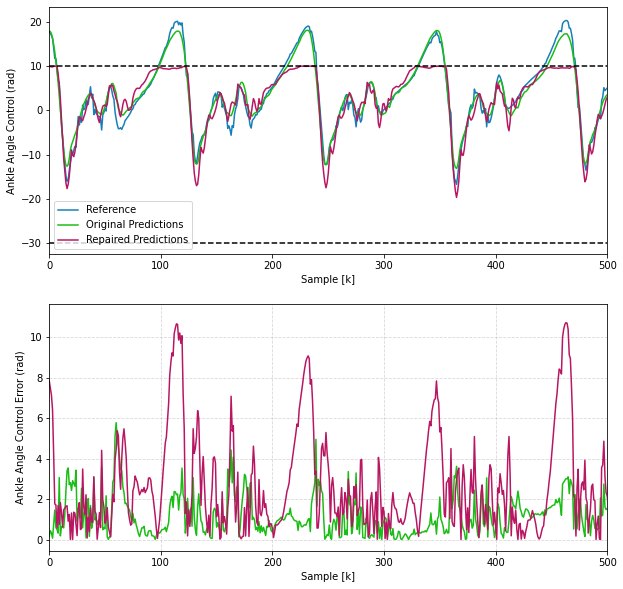

In [12]:
plot_test_data(model_orig, out_model, bound)

As shown in the figure, the network is successfully repaired and the signal follows the bounds.